In [1]:
# automatically apply changes in netgen
%reload_ext autoreload
%autoreload 2

In [5]:
import os, sys
import pandas as pd
import numpy as np
import random
import math
from future.utils import listvalues
from copy import deepcopy

import cbgt.netgen as ng
#import cbgt.analyzefx as afx
#from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'font.family': u'sans-serif',
'font.sans-serif': [u'Helvetica',  u'Arial', u'sans-serif'],
'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', font='Helvetica', rc=rc, font_scale=1.4)
# splot.style(theme='safari-day', grid=True, spines=True, fscale=1.4, figsize=(6., 3.5))
# bdf = pd.read_csv("/Users/kyle/demo_cbgt_bdf.csv")

In [4]:
print "test"

test


## Global Params

In [10]:
parentDir = 'CBGT_Review_Final_Data'


savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)

BaseStim = 0
Stim = 2.54
Dynamic = 30.0
Choices = 2
rampingCTX = True
popscale = .3
Start=600

presetNo = ng.set_post_learning_weights(dMSN=[1.0, 1.0], iMSN=[1.0,1.0])
presetLow = ng.set_post_learning_weights(dMSN=[1.01, 0.99], iMSN=[1.0,1.0])
presetHi = ng.set_post_learning_weights(dMSN=[1.03, 0.98], iMSN=[1.0,1.0])
presets = [presetNo, presetLow, presetHi]

conds = ['no', 'low', 'high']
condABC = ['z', 'a', 'b']
cond12 = [0, 1, 2]

savedirs = [os.path.join(savedir, c) for c in conds]
saveNo, saveLow, saveHi = savedirs
saveTest=os.path.join(savedir, 'test')

presetDict = dict(zip(conds, presets))
condOrder = dict(zip(conds, condABC))
condLevel = dict(zip(conds+['test'], cond12+[0]))

# Efficacy sampling f(x) for individual networks

In [11]:
def get_sampling_params(scale=.05):

    
    CxSTR      =    0.2*.7*.9
    CxTh       =    0.03
    CxFSI      =    0.165*.8
    D1STR_GPi  =    1.10 #1.07
    D2STR_GPeP =    1.65
    STN_GPeP_A =    0.07
    STN_GPeP_N =    4.01
    STN_GPi    =    0.0324
    GPi_Th     =    0.067
    ThSTR      =    0.34*.75
    ThCx       =    0.02

    mu = dict(Cx={'STR':CxSTR, 'Th':CxTh, 'FSI':CxFSI}, 
                Th={'STR':ThSTR, 'Cx':ThCx},
                D1STR={'GPi': D1STR_GPi},
                D2STR={'GPeP': D2STR_GPeP},
                STN={'GPi': STN_GPi},
                GPi={'Th': GPi_Th})
    sd = {i:{j: mu[i][j]*scale for j in list(mu[i])} for i in list(mu)}
    return mu, sd


def sample_network_efficacies(muEff, sdEff, N):
    X = {}
    nuclei = list(muEff)
    for i in nuclei:
        targets = list(muEff[i])
        X[i] = {}
        for j in targets:
            X[i][j] = np.random.normal(muEff[i][j], sdEff[i][j], N)
    return X


def build_single_network(X, idx=0):
    
    Cx={'STR': X['Cx']['STR'][idx], 
        'Th': X['Cx']['Th'][idx], 
        'FSI': X['Cx']['FSI'][idx]}
    
    D1STR={'GPi': X['D1STR']['GPi'][idx]}
    D2STR={'GPeP': X['D2STR']['GPeP'][idx]}
    
    STN={'GPi': X['STN']['GPi'][idx]}
    
    GPi={'Th': X['GPi']['Th'][idx]}
    
    Th={'STR': X['Th']['STR'][idx], 
        'Cx': X['Th']['Cx'][idx]}

    return ng.getConEff(Cx=Cx, D1STR=D1STR, D2STR=D2STR, STN=STN, GPi=GPi, Th=Th)

# Sample 3 individual networks

In [12]:
N_subj = 3
sdScale = .05

conProb = ng.getConProb()
muEff, sdEff = get_sampling_params(sdScale)
X = sample_network_efficacies(muEff, sdEff, N=N_subj)
subj_eff_dicts = [build_single_network(X, idx=i) for i in range(N_subj)]

# Write simulation config files

In [13]:
# get conn. efficacies for 1st subject network (idx=0)
idx = 0
conEff_i = subj_eff_dicts[idx]

# set stimulus strength
stim = 2.5
# get preset for "high" reward condition
# (e.g., Cx-dMSN weight scalars)
preset = presetDict['no']

# set save directory
ng.setDirectory(saveTest)

# configure trial and network parameters
np.random.seed(seed=np.random.randint(0,1000))
sweepcount = ng.configureSweep(0, experiment='mc', preset=preset, Start=Start,
                               popscale=popscale, BaseStim=BaseStim, Choices=Choices, 
                               WrongStim=stim, RightStim=stim, Dynamic=Dynamic,
                               rampingCTX=True,
                               conProb=conProb, 
                               conEff=conEff_i,
                               seed=list(range(0,250)),
                               d1aw=[55],
                               d2aw=[-45],
                               rewardprob=[1.0],
                               dpmn_ratio=0.5,
                               dpmn_implied=0.7
                              )
sweepcount

250

# Run simulations

warning: this takes a few hours with multithreading. If you don't have enough cores it will take a really long time.

In [9]:
# compile current configuration and simulate trial
cores = 23
ng.compileAndRunSweepALL(1, 0, sweepcount, cores) 

In [4]:
# compile current configuration and simulate trial
cores = 23
ng.compileAndRunSweepALL(1, 0, 250, cores) 

# Plot population firing rates

In [9]:
# re-specify working directory

parentDir = 'CBGT_Review_Final_Data'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
saveTest=os.path.join(savedir, 'test')
ng.setDirectory(saveTest)

In [163]:
# massive helper function to create a list of datatables (one per sim) and a paramtable of parameter vectors

def generateFrames(results,decisions):

    datatables = []

    paramtable = pd.DataFrame()
    index = 0
    for confignum in range(0,4):
        for repnum in range(0,1):
            paramvector = pd.DataFrame([[index,confignum,repnum]],columns=['index','confignum','repnum'])
            index += 1
            for key,value in results[confignum][repnum].items():
                if isinstance(value, (float,int,str)):
                    paramvector[key] = value
            paramvector.set_index('index',inplace=True)
            paramtable = paramtable.append(paramvector)

            datatable = pd.DataFrame()

            result = results[confignum][repnum]

            stagecount = len(decisions[confignum][repnum])

            for i in range(0, stagecount):

                row = pd.DataFrame([[i]],columns=['trial'])


                if decisions[confignum][repnum][i]['pathvals'] != None and len(decisions[confignum][repnum][i]['pathvals']) > 0:
                    row['decision'] = decisions[confignum][repnum][i]['pathvals'][0]
                else:
                    row['decision'] = None

                row['stimulusstarttime'] = decisions[confignum][repnum][i]['time'] - decisions[confignum][repnum][i]['delay']
                row['decisiontime'] = decisions[confignum][repnum][i]['time']
                row['decisionduration'] = decisions[confignum][repnum][i]['delay']
                row['decisiondurationplusdelay'] = decisions[confignum][repnum][i]['delay'] + 300
                row['rewardtime'] = decisions[confignum][repnum][i]['time'] + 300

                # NOTE: has to match code in netgen
                row['correctdecision'] = int(i>=20)
                row['reward'] = row.apply(lambda x: int(x.decision == x.correctdecision), axis=1)

                msd = result['popfreqs'][result['popfreqs']['Time (ms)'].between(row.loc[0,'stimulusstarttime'], row.loc[0,'decisiontime'])].drop(columns='Time (ms)').mean().to_frame().T
                isd = msd.copy().multiply(row.loc[0,'decisiontime'] - row.loc[0,'stimulusstarttime']).divide(1000)
                msd.columns = ["msd_" + str(col) for col in msd.columns]
                row = row.join(msd)
                isd.columns = ["isd_" + str(col) for col in isd.columns]
                row = row.join(isd)


                mdr = result['popfreqs'][result['popfreqs']['Time (ms)'].between(row.loc[0,'decisiontime'], row.loc[0,'rewardtime'])].drop(columns='Time (ms)').mean().to_frame().T
                idr = mdr.copy().multiply(row.loc[0,'rewardtime'] - row.loc[0,'decisiontime']).divide(1000)
                mdr.columns = ["mdr_" + str(col) for col in mdr.columns]
                row = row.join(mdr)
                idr.columns = ["idr_" + str(col) for col in idr.columns]
                row = row.join(idr)


                msr = result['popfreqs'][result['popfreqs']['Time (ms)'].between(row.loc[0,'stimulusstarttime'], row.loc[0,'rewardtime'])].drop(columns='Time (ms)').mean().to_frame().T
                isr = msr.copy().multiply(row.loc[0,'rewardtime'] - row.loc[0,'stimulusstarttime']).divide(1000)
                msr.columns = ["msr_" + str(col) for col in msr.columns]
                row = row.join(msr)
                isr.columns = ["isr_" + str(col) for col in isr.columns]
                row = row.join(isr)


                datatable = datatable.append(row)


            datatable.set_index('trial',inplace=True)
            datatables.append(datatable)


    nunique = paramtable.apply(pd.Series.nunique)
    cols_to_keep = pd.Index(['confignum','repnum']).append(nunique[nunique > 1].index).unique()
    paramtable = paramtable[cols_to_keep]
    
    return (paramtable,datatables)

In [5]:
# read in all population firing rates for all sims

results = ng.readAllTrialResults(1,0,250,['popfreqs'])
decisions = []
for sn in range(4):
    decisions.append([])
    for result in results[sn]:
        decisions[sn].append(ng.findOutputs2(result)['decision made'])

In [7]:
decisions = []
for sn in range(250):
    decisions.append([])
    for result in results[sn]:
        decisions[sn].append(ng.findOutputs2(result)['decision made'])

In [11]:
#### read in detailed info for the first 5 sims

resultsB = ng.readAllTrialResults(1,0,250,['popfreqs','popweights','popQ1s','popQ2s','dopamine', 'popEs']) 
decisionsB = []
for sn in range(250):
    decisionsB.append([])
    for result in resultsB[sn]:
        decisionsB[sn].append(ng.findOutputs2(result)['decision made'])

In [164]:
# pick one of the results/decisions pairs and create the tables based off it

(paramtable,datatables) = generateFrames(results,decisions)

In [8]:
# compile decision data for figure

decisiondata = pd.DataFrame(columns=['sim','trial','decision'])
simcount = 250
stagecount = 50
j = 0
for sn in range(0,simcount):
    for i in range(0, stagecount):
        dec = 0.5
        if decisions[sn][0][i]['pathvals'] != None and len(decisions[sn][0][i]['pathvals']) > 0:
            if decisions[sn][0][i]['pathvals'][0] == 0:
                dec = 1
            if decisions[sn][0][i]['pathvals'][0] == 1:
                dec = 0
        decisiondata.loc[j] = [sn, i+1, dec]
        j += 1

decisiondata["sim"] = pd.to_numeric(decisiondata["sim"])
decisiondata["trial"] = pd.to_numeric(decisiondata["trial"])
decisiondata["decision"] = pd.to_numeric(decisiondata["decision"])

In [12]:
# compile decision data for figure

decisiondataB = pd.DataFrame(columns=['sim','trial','decision'])
simcount = 250
stagecount = 50
j = 0
for sn in range(0,simcount):
    for i in range(0, stagecount):
        dec = 0.5
        if decisionsB[sn][0][i]['pathvals'] != None and len(decisionsB[sn][0][i]['pathvals']) > 0:
            if decisionsB[sn][0][i]['pathvals'][0] == 0:
                dec = 1
            if decisionsB[sn][0][i]['pathvals'][0] == 1:
                dec = 0
        decisiondataB.loc[j] = [sn, i+1, dec]
        j += 1

decisiondataB["sim"] = pd.to_numeric(decisiondataB["sim"])
decisiondataB["trial"] = pd.to_numeric(decisiondataB["trial"])
decisiondataB["decision"] = pd.to_numeric(decisiondataB["decision"])

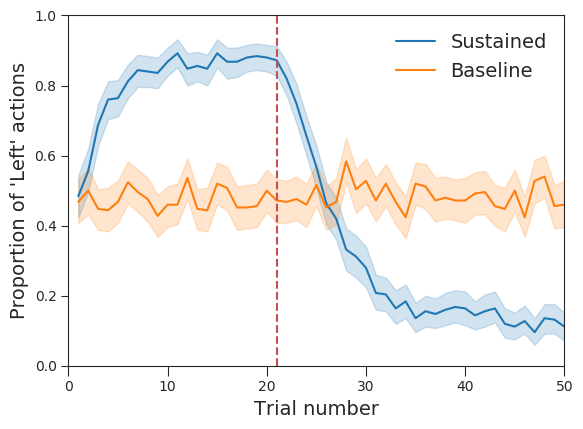

In [28]:
# switch case figure
sns.reset_orig()
sns.set_style("ticks")
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
ax = sns.lineplot(x="trial", y="decision", data=decisiondataB, ci=95)
ax = sns.lineplot(x="trial", y="decision", data=decisiondata, ci=95)
ax.set_facecolor('w')
ax.set_ylabel("Proportion of 'Left' actions", fontsize=14)
ax.set_xlabel("Trial number", fontsize=14)
ax.set_ylim(0,1)
ax.set_xlim(0,50)
ax.axvline(21, color='r', linestyle='--')
ax.legend(['Sustained','Baseline'],loc='upper right',fontsize=14,frameon=False)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("fig1.png",dpi=1200)

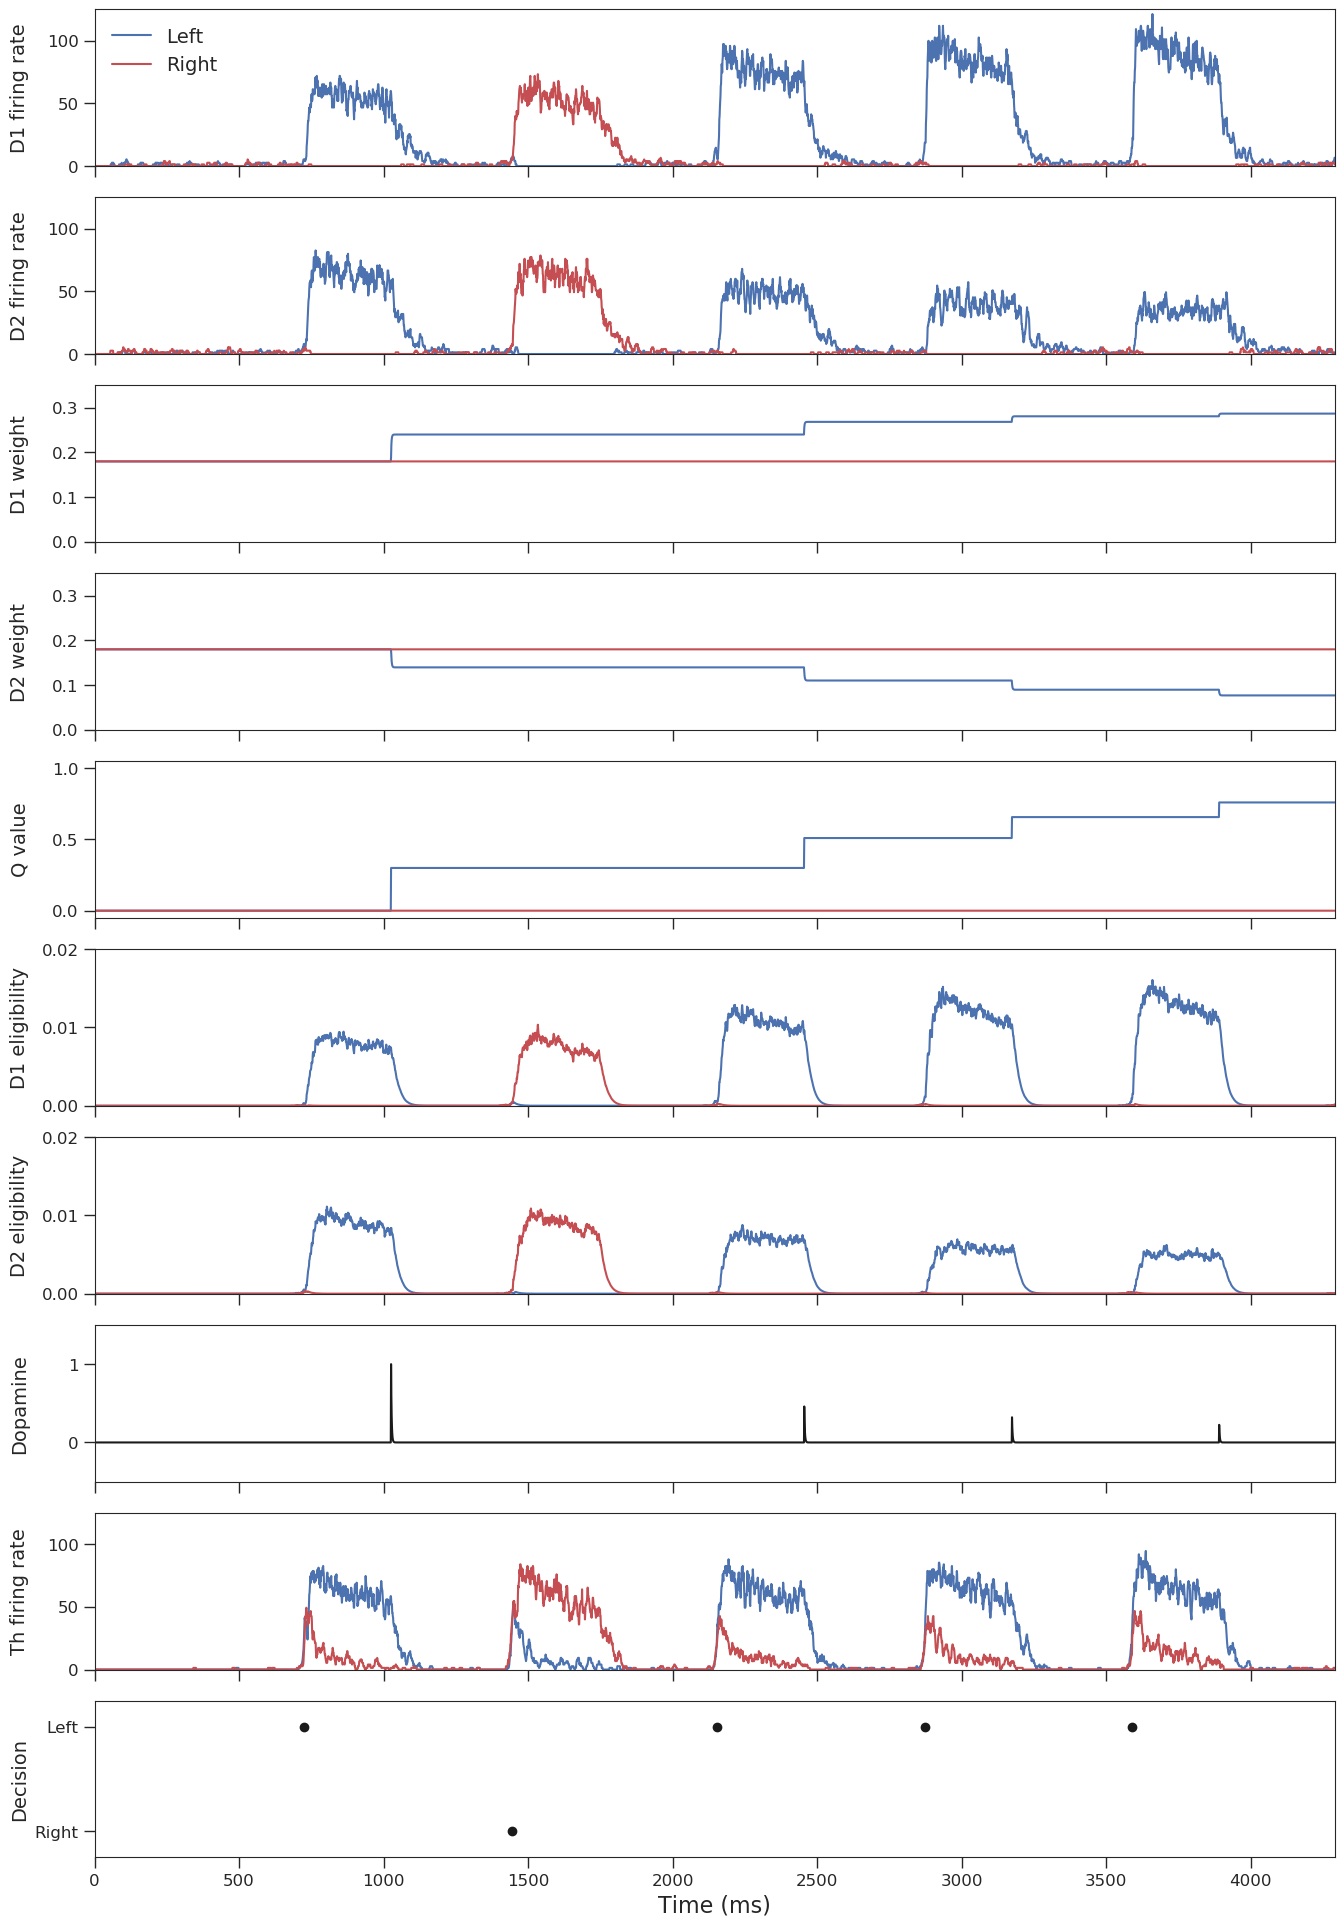

In [29]:
# plot a few trials from a single sim for a detailed figure

from cycler import cycler

sns.reset_orig()
sns.set_style("ticks")

plt.rcParams['axes.prop_cycle'] = cycler(color='brmrcmykg')

confignum = 4
repnum = 0

result = resultsB[confignum][repnum]

stagecount = len(decisionsB[confignum][repnum])
reacttimes = []
reactions = []
allreactions = []
for i in range(0, stagecount):
    if decisionsB[confignum][repnum][i]['pathvals'] != None and len(decisionsB[confignum][repnum][i]['pathvals']) > 0:
        reactions.append(1-decisionsB[confignum][repnum][i]['pathvals'][0])
    else:
        reactions.append(0.5)
    reacttimes.append(decisionsB[confignum][repnum][i]['time'])

f, (ax1, ax2, ax3, ax4, ax5, ax7, ax8, ax9, ax10, ax11) = plt.subplots(10, 1, figsize=(16,24), sharex=True)

for i in range(0,result['dims']['choices']):
    result['popfreqs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax1)
    result['popfreqs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax2)
    result['popweights'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax3)
    result['popweights'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax4)
    result['popEs'].plot(x='Time (ms)', y='D1STR_'+str(i)+'_0', ax=ax7)
    result['popEs'].plot(x='Time (ms)', y='D2STR_'+str(i)+'_0', ax=ax8)
    result['popfreqs'].plot(x='Time (ms)', y='Th_'+str(i)+'_0', ax=ax10)


result['dopamine'].plot(x='Time (ms)', y='D1STR_0_0', ax=ax9, color='k')

result['popQ1s'].plot(x='Time (ms)', y='D1STR_0_0', ax=ax5)
result['popQ2s'].plot(x='Time (ms)', y='D1STR_0_0', ax=ax5)



ax11.plot(reacttimes,reactions, marker='o', linestyle='None', color='k')
#ax11.plot([reacttimes[i] for i in [0,2,3,4]],[reactions[i] for i in [0,2,3,4]], marker='o', linestyle='None', markersize=10)
#ax11.plot([reacttimes[i] for i in [1]],[reactions[i] for i in [1]], marker='o', linestyle='None', markersize=10)

ax11.set_ylim(-0.25,1.25)
ax11.set_xlim(0,reacttimes[4]+700)

ax1.set_ylim(.0,125)
ax2.set_ylim(.0,125)
ax3.set_ylim(.0,.35)
ax4.set_ylim(.0,.35)
ax7.set_ylim(.0,.02)
ax8.set_ylim(.0,.02)
ax9.set_ylim(-.5,1.5)
ax10.set_ylim(0,125)

labels = [item.get_text() for item in ax11.get_yticklabels()]
labels[1] = 'Right'
labels[2] = 'Left'
ax11.set_yticklabels(labels)

ax1.set_ylabel('D1 firing rate', fontsize=14)
ax2.set_ylabel('D2 firing rate', fontsize=14)
ax3.set_ylabel('D1 weight', fontsize=14)
ax4.set_ylabel('D2 weight', fontsize=14)
ax5.set_ylabel('Q value', fontsize=14)
ax7.set_ylabel('D1 eligibility', fontsize=14)
ax8.set_ylabel('D2 eligibility', fontsize=14)
ax9.set_ylabel('Dopamine', fontsize=14)
ax10.set_ylabel('Th firing rate', fontsize=14)
ax11.set_ylabel('Decision', fontsize=14)
f.align_ylabels()

ax11.set_xlabel("Time (ms)", fontsize=16)

ax1.legend(['Left','Right'],loc='upper left',fontsize=14,frameon=False)
ax2.get_legend().remove()
ax3.get_legend().remove()
ax4.get_legend().remove()
ax5.get_legend().remove()
ax7.get_legend().remove()
ax8.get_legend().remove()
ax9.get_legend().remove()
ax10.get_legend().remove()

f.set_facecolor('w')

ax1.tick_params(labelsize='large',width=1,length=8)
ax2.tick_params(labelsize='large',width=1,length=8)
ax3.tick_params(labelsize='large',width=1,length=8)
ax4.tick_params(labelsize='large',width=1,length=8)
ax5.tick_params(labelsize='large',width=1,length=8)
ax7.tick_params(labelsize='large',width=1,length=8)
ax8.tick_params(labelsize='large',width=1,length=8)
ax9.tick_params(labelsize='large',width=1,length=8)
ax10.tick_params(labelsize='large',width=1,length=8)
ax11.tick_params(labelsize='large',width=1,length=8)

ax7.locator_params(axis = 'y', nbins = 2)
ax8.locator_params(axis = 'y', nbins = 2)
ax9.locator_params(axis = 'y', nbins = 2)
ax11.locator_params(axis = 'y', nbins = 1)
plt.savefig("fig2.png",dpi=1200)

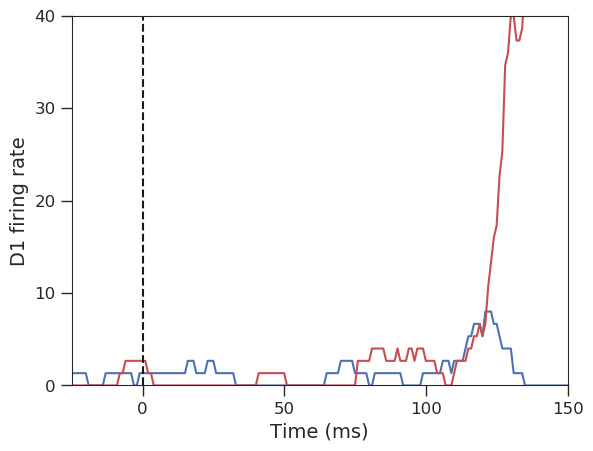

In [30]:
shiftedtime = result['popfreqs'].copy()
shiftedtime['Time (ms)'] = shiftedtime['Time (ms)'] - (reacttimes[0]+600)
f, (ax1) = plt.subplots(1, 1)
f.set_facecolor('w')
shiftedtime.plot(x='Time (ms)', y='D1STR_0_0', ax=ax1)
shiftedtime.plot(x='Time (ms)', y='D1STR_1_0', ax=ax1)
ax1.set_xlim(-25,150)
ax1.set_ylim(0,40)
ax1.get_legend().remove()
ax1.set_ylabel('D1 firing rate', fontsize=14)
ax1.set_xlabel('Time (ms)', fontsize=14)
ax1.axvline(0, color='k', linestyle='--')
ax1.tick_params(labelsize='large',width=1,length=8)
ax1.locator_params(axis = 'x', nbins = 4)
ax1.locator_params(axis = 'y', nbins = 4)
plt.savefig("fig3.png",dpi=1200)

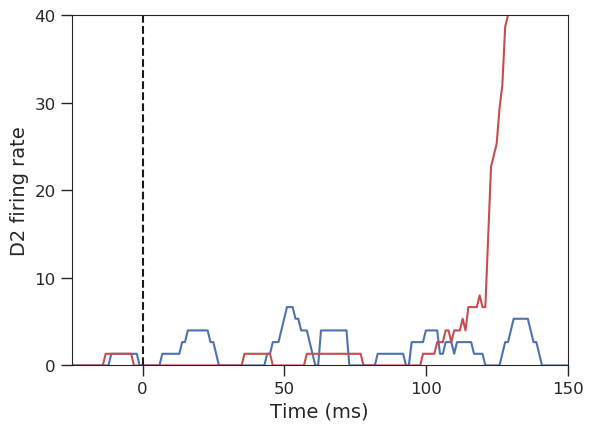

In [31]:
shiftedtime = result['popfreqs'].copy()
shiftedtime['Time (ms)'] = shiftedtime['Time (ms)'] - (reacttimes[0]+600)
f, (ax1) = plt.subplots(1, 1)
f.set_facecolor('w')
shiftedtime.plot(x='Time (ms)', y='D2STR_0_0', ax=ax1)
shiftedtime.plot(x='Time (ms)', y='D2STR_1_0', ax=ax1)
ax1.set_xlim(-25,150)
ax1.set_ylim(0,40)
ax1.get_legend().remove()
ax1.set_ylabel('D2 firing rate', fontsize=14)
ax1.set_xlabel('Time (ms)', fontsize=14)
ax1.axvline(0, color='k', linestyle='--')
ax1.tick_params(labelsize='large',width=1,length=8)
ax1.locator_params(axis = 'x', nbins = 4)
ax1.locator_params(axis = 'y', nbins = 4)
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig("fig5.png",dpi=1200)

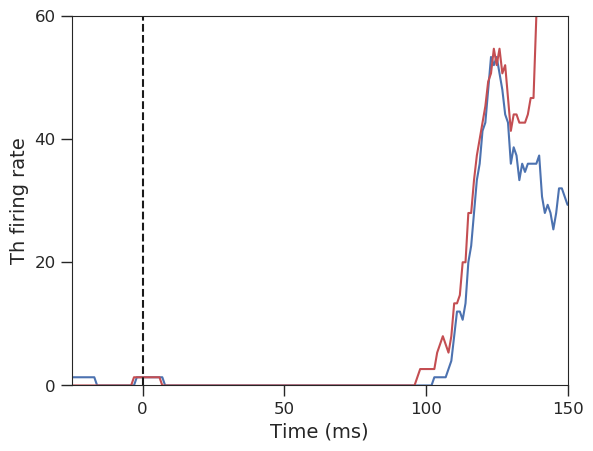

In [32]:
shiftedtime = result['popfreqs'].copy()
shiftedtime['Time (ms)'] = shiftedtime['Time (ms)'] - (reacttimes[0]+600)
f, (ax1) = plt.subplots(1, 1)
f.set_facecolor('w')
shiftedtime.plot(x='Time (ms)', y='Th_0_0', ax=ax1)
shiftedtime.plot(x='Time (ms)', y='Th_1_0', ax=ax1)
ax1.set_xlim(-25,150)
ax1.set_ylim(0,60)
ax1.get_legend().remove()
ax1.set_ylabel('Th firing rate', fontsize=14)
ax1.set_xlabel('Time (ms)', fontsize=14)
ax1.axvline(0, color='k', linestyle='--')
ax1.tick_params(labelsize='large',width=1,length=8)
ax1.locator_params(axis = 'x', nbins = 4)
ax1.locator_params(axis = 'y', nbins = 3)
plt.savefig("fig4.png",dpi=1200)

In [33]:
print "h"

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("h")? (<ipython-input-33-4dd5617b74b4>, line 1)